# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime

pd.set_option('mode.chained_assignment', None)

In [154]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler

# Data exploration

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Lets perform data review to verify completenes of data and main characteristics

##### a. Offer portfolio data


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.id.nunique()

10

In [7]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

As visible above, the portfolio dataframe has no missing values. Based on `id` column we can confirm that there are 10 unique offers in dataframe. 3 types of offers are:

* BOGO - buy one get one free
* Discount - discount with purchase
* Informational - provides information about products


Lets convert `channels` column lists to separate columns with some `bool` encoding.

In [8]:
channels_df = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, channels_df], axis=1)
portfolio.drop(['channels'], axis=1, inplace=True)

C:\Users\Komp\AppData\Local\Temp\ipykernel_5248\3790530.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  channels_df = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)


In [9]:
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


##### b. Demografic data



**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.shape

(17000, 5)

In [12]:
print('Number of unique customers:', profile.id.nunique())

Number of unique customers: 17000


In [13]:
print(profile.isnull().sum())
print(profile.isnull().sum()*100/len(profile))

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64


As we can see there is around 13% missing values in `gender` and `income` columns

In [14]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


Text(0, 0.5, 'Count')

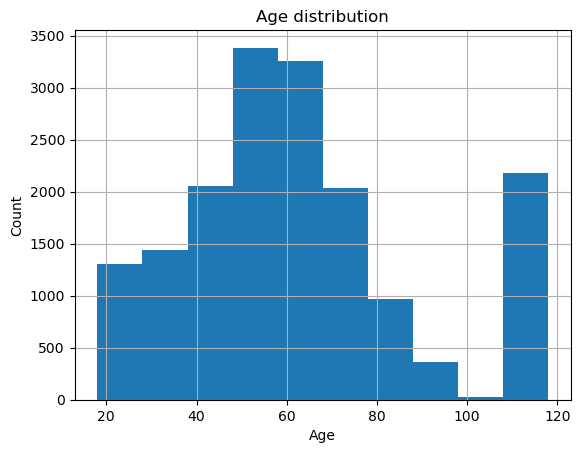

In [15]:
profile.age.hist()
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")

In [16]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

After checking the missing data in profile dataframe I noticed that these might be some incorrect entries as both `gender` and `income` are `None`, plus `age = 118` years. Therefore I decide to drop these lines from dataframe as it's only 13%

In [17]:
profile.dropna(inplace=True)

Text(0, 0.5, 'Count')

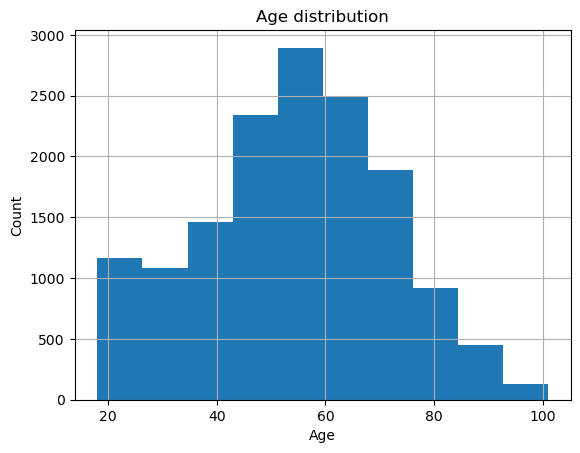

In [18]:
profile.age.hist()
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")

After removing missing values the `age` distribution looks much more reasonable

Lets now focus on the `become_member_on` column. First lets apply proper date formatting plus calculate `membership_time` to verify the longest Starbucks loyalty club customers

In [19]:
profile = profile.rename(columns = {'id': 'customer_id'})
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_time'] = (datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date).dt.days

In [20]:
profile.head()

,gender,age,customer_id,became_member_on,income,membership_time
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2148
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2215
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1863
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1939
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2029


Text(0, 0.5, 'Count')

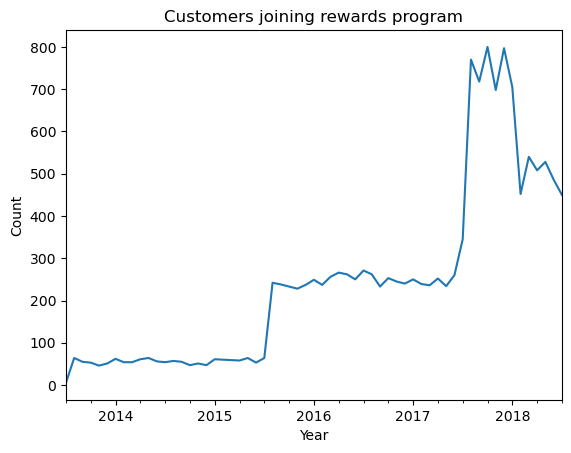

In [21]:
profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count().plot.line()
plt.title("Customers joining rewards program")
plt.xlabel("Year")
plt.ylabel("Count")

As you can see the number of customers joining the program increased over time up to `2018` where first, significant drop was visible. There are also two significant spikes in `2015Q2` and `2017Q1`

In [22]:
def distribution_by_gender(df: pd.DataFrame, col: str):
    """Returns a distribution plot of specified column  in df per gender
    
    Parameters:
    df (pd.DataFrame):dataframe with variables
    col (str): variable to be plotted
    
    Returns:
    plot (plt.hist): histogram and density plot
    
    """
    sns.set(style = 'whitegrid')
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(15,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.histplot(df[df['gender'] == 'M'][col], stat="density", kde=True, bins = 10, color = palette[0]);
    plt.title('Male\'s {} distribution'.format(col))
    plt.xlabel(f'{col}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.histplot(df[df['gender'] == 'F'][col],  stat="density", kde=True, bins = 10, color = palette[1]);
    plt.title('Female\'s {} distribution'.format(col))
    plt.xlabel(f'{col}')

    plt.sca(ax[2])
    sns.histplot(df[df['gender'] == 'O'][col],  stat="density", kde=True, bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(col))
    plt.xlabel(f'{col}')
    plt.show()

    return plt

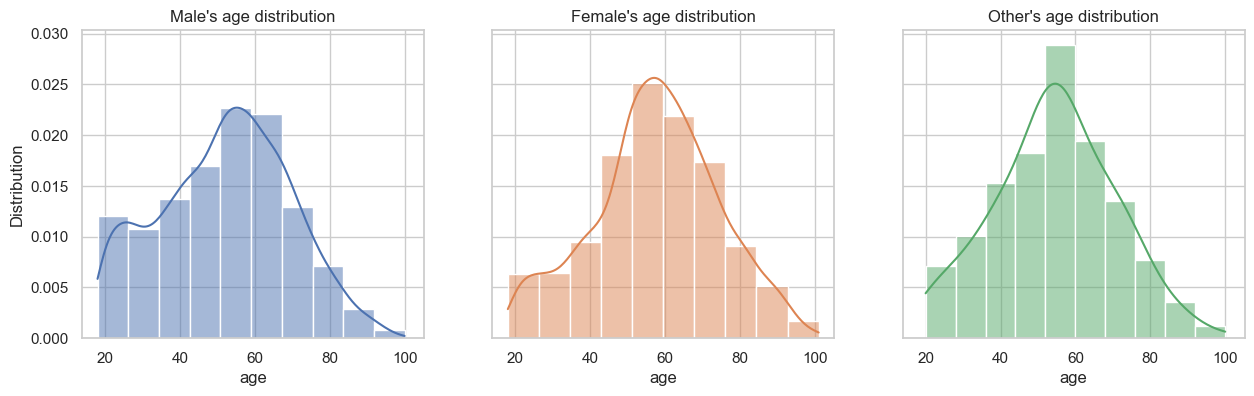

<module 'matplotlib.pyplot' from 'C:\\Users\\Komp\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [23]:
distribution_by_gender(profile, 'age')

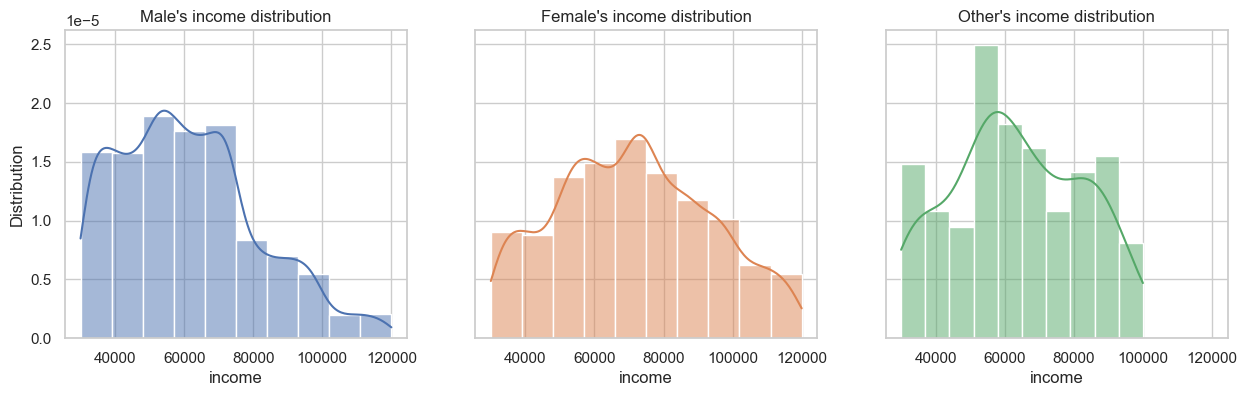

<module 'matplotlib.pyplot' from 'C:\\Users\\Komp\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:
distribution_by_gender(profile, 'income')

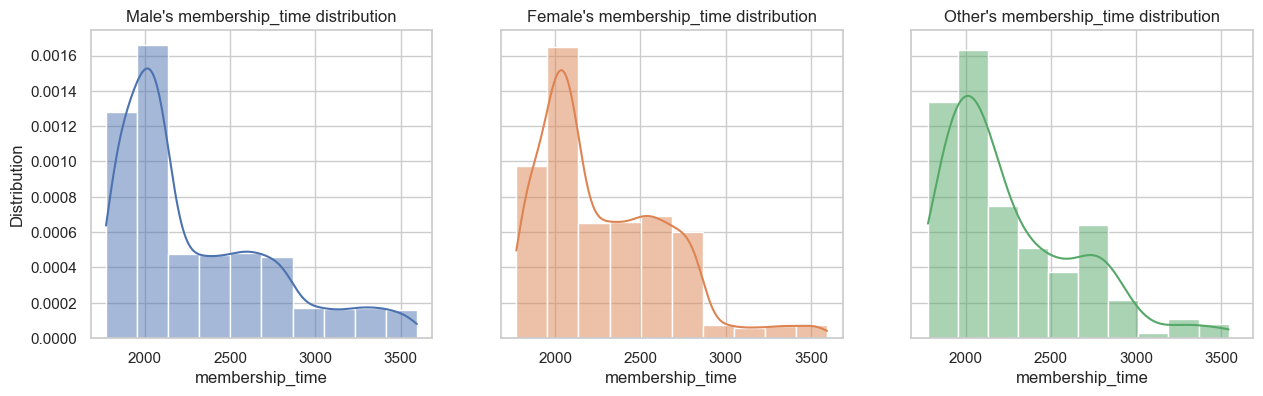

<module 'matplotlib.pyplot' from 'C:\\Users\\Komp\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [25]:
distribution_by_gender(profile, 'membership_time')

The age distribution looks more or less similar between genders. Though there is slight difference in similarity in case of male users, where a significant group of users close to 20 years old is visible. The other two genders have closer to  normal distribution.
Interestingly in terms of income there is a visible right skewed shape on male's graph. Female one looks closer to normal distribution. It seems that men using the app do in general earn less.

##### c. Transcript data

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [26]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
transcript.shape

(306534, 4)

In [28]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [29]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

No missing data in `transcript` dataframe. 4 types of events in `event` column of the dataframe. Lets extract the value column dict values into separate columns

In [30]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


There are two offer_id columns in the dataset so lets make sure we have one with all potential inputs

In [31]:
transcript['temp_id'] = np.where(transcript['offer id'].isnull(), transcript['offer_id'], transcript['offer id'])
transcript.drop(['offer id', 'offer_id', 'value'], axis=1, inplace=True)
transcript.rename(columns={'temp_id': 'offer_id', 'person':'customer_id'}, inplace=True)

In [32]:
transcript.isna().sum()

customer_id         0
event               0
time                0
amount         167581
reward         272955
offer_id       138953
dtype: int64

In [33]:
print('Number of unique offers:',transcript.offer_id.nunique())
print('Number of unique people:', transcript.customer_id.nunique())

Number of unique offers: 10
Number of unique people: 17000


Both the `profile` and `transcript` dataframes contain same number od customers
Both the `portfolio` and `transcript` dataframes contain same number od offers

In [34]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [35]:
transcript.head()

,customer_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


# Data preprocessing

Before going to data modelling I need to rethink the way I will separate effective offer from ineffective one. That data will be then used to identify main drivers of the successful offers.

As shown in the data there are 4 types of events: `offer completed`, `offer received`, `offer view`, and `transaction`. However there is not data showing us the transactions itself, therefore we need to establish the methodology that will allow as to identify the offers that ended with success and the ones that did not.

For a `BOGO` and `discount offer`, an effective offer would be defined if the following events were recorded in the right sequence in time:

`offer received -> offer viewed -> transaction -> offer completed`

Meanwhile, for an `informational offer`, since there offer completed event associated with it, I will have to define transactions as a conversion to effective offer:

`offer received -> offer viewed -> transaction`

1. People who are influenced and successfully complete - effective offers:

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

2. People who received and viewed an offer but did not successfully complete - ineffective offers:

- `offer received` -> `offer viewed`

3. People who purchase/complete offers regardless of awareness of any offers:

- `transaction`
- `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
- `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
- `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
- `offer received` -> `transaction` (informational offers)
- `offer received` -> `transaction` -> `offer viewed` (informational offers)

4. People who received offers but no action taken:

- `offer received`



###### Updating the offer_id for transactions

Lets sort the transcript data by `customer_id` and `time` to make sure we have a right sequence of events. Based on the new df I will fill nan values in `offer_id` column for transactions to identify the transactions for specific offers in the next step

In [36]:
transcript = transcript.sort_values(['customer_id','time'])

In [37]:
transcript.head()

,customer_id,event,time,amount,reward,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


I will update the nan `offer_id`, column for the `transcaction` type events

In [38]:
success_offers = transcript[['time','offer_id','customer_id','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')]
success_offers['offer_id'] = success_offers['offer_id'].ffill()

In [39]:
success_offers.isna().sum()

time           0
offer_id       0
customer_id    0
event          0
dtype: int64

In [40]:
transcript = transcript.merge(success_offers, how='left', on=['customer_id','time','event'])
transcript['offer_id'] = np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'], transcript['offer_id_x'])
transcript.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [41]:
transcript.head()

,customer_id,event,time,amount,reward,offer_id
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


Lets combine the transcript data with portfolio to get more information in one dataframe

In [42]:
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.drop(['reward_x'], axis=1, inplace=True)
combined.rename(columns={'reward_y': 'reward'}, inplace=True)

In [43]:
combined.head()

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1


Text(0.5, 1.0, 'Types or events per offer_type')

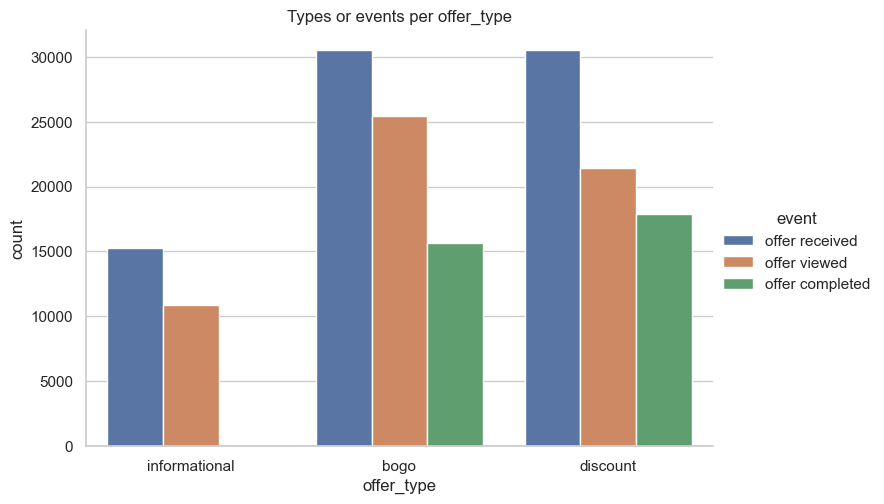

In [44]:
sns.catplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)
plt.title('Types or events per offer_type')

In [45]:
combined.head()

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1


###### Identify successful transactions

Lets now flag all the transactions that ended successfully. As we already identified the right `offer_id` for transactions we just need to make sure that a right sequence of `events`before the transaction occurred. This will lead us to focus mostly on `Group 1` of people who where successfully influenced by the offer. `success==1`

`Group 2` of people would therefore go to the the ineffective offer area `success==0`

What should we do with the people from `Group 3 and 4`? From business perspective they are not important. `Group 3` people do the transactions regardless receiving any offers. `Group 4` do not even view them or make transactions. So these are not groups we should target when sending the offers at all. So we will exclude them in the further part before data modelling.

To identify successful offers we need to make sure that the `offer_id` of transaction is the same as `offer_id` of previous event. Then if we have right sequence of events with the same `offer_id`, this will be a confirmation of the successful offer.

To achieve this I will create new column with `prev_offer_id` using `shift` pandas function.

In [46]:
success_offers = combined[(combined['event']=='offer viewed')|(combined['event']=='transaction')|(combined['event']=='offer completed')].copy(deep=True)
success_offers['prev_offer_id'] = success_offers.groupby(['customer_id','offer_id'])['offer_id'].shift()
success_offers['success'] = np.where(success_offers['prev_offer_id']==success_offers['offer_id'],1,0)

In [47]:
success_offers.head(2)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,5a8bc65990b245e5a138643cd4eb9837,1


Now lets extract the `offer received` rows from our original dataframe so that we can combine that agaiun with our enhanced `success_offers` table.

In [48]:
received_offers = combined[combined['event']=='offer received']
received_offers['prev_offer_id'] = np.nan
received_offers['success'] = 0

combined = pd.concat([received_offers, success_offers]).sort_values(['customer_id','time'])
combined.head(2)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0


As we identyfied the succesful transactions we can now focus on analysis of the specific offer types as all 3 of them have different conversion ways.

###### Spliting data in to offer types

In [49]:
def split_by_offer_type(input_df, offer_type):
    """Returns a dataframe for specific offer type
    
    Parameters:
    input_df (pd.DataFrame): dataframe with all offers
    offer_type (str): offer type
    
    Returns:
    df (pd.DataFrame):dataframe only with specific offer
    
    """
    df = input_df[input_df['offer_type']==offer_type].copy()
    return df

#split transcript into 3 different offer types

bogo_df = split_by_offer_type(combined, 'bogo')
discount_df = split_by_offer_type(combined, 'discount')
info_df = split_by_offer_type(combined, 'informational')

Based on the current data we can identify people from `Group 1` and all the `offer_ids` with `success==1` for each datasets (effective offers). We have to remember that for `BOGO` and `discount` offers the effective offer is the one ended with `offer completed event`. For `informational` offers this will be `transaction` event respectively.

Now we can extract the `Group 1` people from `BOGO` and `discount` datasets. For `informational` dataset additional condition has to be taken into consideration. The transactions have to occurred within the validity period of an offer to recognize this as effective offer.

###### Extracting Group 1 and Group 2 customers and offers for BOGO and discount offers

In [50]:
bogo_df.head()

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success
5,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,NaN,0
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,NaN,0
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,1
10,0009655768c64bdeb2e877511632db8f,transaction,528,14.11,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,1
20,00116118485d4dfda04fdbaba9a87b5c,offer received,168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1,NaN,0


In [51]:
def group1_df(input_df):
    """Returns a dataframe for group 1
    
    Parameters:
    input_df (pd.DataFrame): dataframe with all offers
    
    Returns:
    df (pd.DataFrame):dataframe only with group 1
    
    """
    df = input_df[['customer_id','offer_id']][(input_df['success']==1) & (input_df['event']=='offer completed')].groupby(['customer_id','offer_id']).count().reset_index()
    return df

In [52]:
bogo_gr1 = group1_df(bogo_df)
discount_gr1 = group1_df(discount_df)

In [53]:
bogo_gr1.head()

,customer_id,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d


Let's create the `Group 2` dataframe both for `BOGO` and `discount` offers so that we have both scenario paths for model training.

In [54]:
def group2_df(input_df, combined_df):
    """Returns a dataframe for group 2
    
    Parameters:
    input_df (pd.DataFrame): dataframe with all specific type offers
    combined_df (pd.DataFrame): original dataframe with all offers
    
    Returns:
    df_viewed (pd.DataFrame): dataframe only with group 2
    
    """
    df_ids_transaction_completed = input_df[['customer_id','offer_id']][(input_df['event']=='transaction') | (input_df['event']=='offer completed')].groupby(['customer_id','offer_id']).count().reset_index()
    df_ids_received = input_df[['customer_id','offer_id']][input_df['event']=='offer received'].groupby(['customer_id','offer_id']).count().reset_index()

    # get the offer records which was only viewed without transaction and completion
    df_merged = df_ids_transaction_completed.merge(df_ids_received,how='right',on=['customer_id','offer_id'],indicator=True)
    
    # subtract the customers who received the offer without finishing the transaction
    df_no_transaction = df_merged[df_merged['_merge']=='right_only']
    df_no_transaction = df_no_transaction.merge(combined_df, how='left',on=['customer_id','offer_id'])

    # separate users who only viewed the offer and didn't make transaction
    df_viewed = df_no_transaction[['customer_id','offer_id']][df_no_transaction['event']=='offer viewed']\
                    .groupby(['customer_id','offer_id']).count().reset_index()
    
    return df_viewed

In [55]:
bogo_gr2 = group2_df(bogo_df, combined)
discount_gr2 = group2_df(discount_df, combined)

In [56]:
bogo_gr2.head()

,customer_id,offer_id
0,0063def0f9c14bc4805322a488839b32,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d
2,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0
3,0092a132ead946ceb30d11a1ed513d20,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,0092a132ead946ceb30d11a1ed513d20,ae264e3637204a6fb9bb56bc8210ddfd


Now as we have both `Group 1` and `Group 2` customers and offers identified lets combined them into one dataset

In [57]:
def combine_datasets(group1_df, group2_df):
    """Returns a combined dataframe with additional responded flag
    
    Parameters:
    df1 (pd.DataFrame): dataframe with all Group 1 customers
    df2 (pd.DataFrame): dataframe with all Group 2 customers
    
    Returns:
    df (pd.DataFrame): combinbed dataframe consisting of Group 1 and 2
    
    """
    group1_df['offer_responded'] = 1
    group2_df['offer_responded'] = 0
    df = pd.concat([group1_df, group2_df], sort=False)
    return df

In [58]:
gr1and2_bogo = combine_datasets(bogo_gr1, bogo_gr2)
gr1and2_discount = combine_datasets(discount_gr1, discount_gr2)

###### Preparing informational type dataset

As I wrote above, informational offer can only be successful when the thransaction happens during offer duration. Lets clean the `info_df` data to be able to indetify such offers.

We have `time` column which is the information when event happened and `duration` column infoming us how long did the offer last.

In [59]:
info_df.head(2)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0


In [60]:
#convert time into days
info_df['num_days'] = info_df['time']/24

# count the days between receiving the offer and transactions
info_df['full_cycle'] = info_df[(info_df['offer_type']=='informational') & ((info_df['event']=='offer received')| (info_df['event']=='transaction'))].groupby(['customer_id','offer_id'])['num_days'].diff()

# create a flag column
info_df['on_time']=np.nan

# flag valid events if within duration
info_df.loc[info_df['full_cycle']<=info_df['duration'],'on_time'] = 1
info_df['on_time']=info_df['on_time'].fillna(value=0)

In [61]:
info_df.head(2)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success,num_days,full_cycle,on_time
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0,7.0,NaN,0.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0,8.0,NaN,0.0


Now looking at the data in `info_df` and two flag columns (`success`, and `on_time`) we can see 4 potential scenarios:

1. Transasction happened in right sequence and on time - effective offers

2. Transasction happened in right sequence and nut not on time

3. Transasction happened in incorrect sequence but on time

4. Transasction happened both in incorrect sequence and time


Only scenario 1 is the effective offer, lets flag it in the dataset

In [62]:
info_df['offer_responded']=np.where(((info_df['success']==1) & (info_df['on_time']==1)),1,0)


In [63]:
info_df.head(2)

,customer_id,event,time,amount,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,prev_offer_id,success,num_days,full_cycle,on_time,offer_responded
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0,7.0,NaN,0.0,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0,NaN,0,8.0,NaN,0.0,0


###### Separating Group 1 and 2 in informational offer type dataset

In [64]:
info_gr1 = info_df[['customer_id','offer_id']][info_df['offer_responded']==1].groupby(['customer_id','offer_id']).sum().reset_index()

Now we have to separate group 2. We can use similar steps to what we did with `BOGO` and `Discount` offers, since we don't have the duration consideration.

In [65]:
info_gr2 = group2_df(info_df, combined)

Let's combine the 

In [66]:
gr1and2_info = combine_datasets(info_gr1, info_gr2)

In [67]:
gr1and2_info.head(2)

,customer_id,offer_id,offer_responded
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


###### Adding profile data to all 3 datasets

We still did not use `profile` dataset to add additional information to our data. Lets do this now and try to create new features based on existing ones

In [68]:
profile.head(2)

,gender,age,customer_id,became_member_on,income,membership_time
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2148
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2215


In [69]:
gr1and2_bogo = gr1and2_bogo.merge(profile, how='left', on='customer_id')
gr1and2_discount = gr1and2_discount.merge(profile, how='left', on='customer_id')
gr1and2_info = gr1and2_info.merge(profile, how='left', on='customer_id')

In [70]:
gr1and2_bogo

,customer_id,offer_id,offer_responded,gender,age,became_member_on,income,membership_time
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,O,40.0,2018-01-09,57000.0,1970.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,F,59.0,2016-03-04,90000.0,2646.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,F,24.0,2016-11-11,60000.0,2394.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,F,24.0,2016-11-11,60000.0,2394.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,F,55.0,2018-05-08,74000.0,1851.0
...,...,...,...,...,...,...,...,...
13215,ffda4545e7084ff6aaf01304fb1c1fa6,f19421c1d4aa40978ebb69ca19b0e20d,0,F,67.0,2018-07-21,95000.0,1777.0
13216,ffed75d3abc64b488982f50ed12878b5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,M,20.0,2018-03-15,44000.0,1905.0
13217,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,0,M,20.0,2018-03-15,44000.0,1905.0
13218,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,0,M,71.0,2017-10-31,73000.0,2040.0


###### Preparing data for modelling

Before data modelling we need to perform final data cleaning eexercise:

a. Check and do something with missing values

b. Convert gender into dummy variables

c. Add portfolio data to get the channels columns

d. Verify if there are any duplicate records

In [71]:
(gr1and2_bogo.isnull().sum()/len(gr1and2_bogo)*100).sort_values(ascending=False).head()

gender              7.057489
age                 7.057489
became_member_on    7.057489
income              7.057489
membership_time     7.057489
dtype: float64

In [72]:
(gr1and2_discount.isnull().sum()/len(gr1and2_discount)*100).sort_values(ascending=False).head()

gender              8.453846
age                 8.453846
became_member_on    8.453846
income              8.453846
membership_time     8.453846
dtype: float64

In [73]:
(gr1and2_info.isnull().sum()/len(gr1and2_info)*100).sort_values(ascending=False).head()

gender              13.087935
age                 13.087935
became_member_on    13.087935
income              13.087935
membership_time     13.087935
dtype: float64

As the % of missing values for 5 columns ais similar it proves that missing data impact same rows of data and all these specific customers do have these information missing. As the missing % is not very significant and the additional data might improve our prediction model I decide to drop them

In [74]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [75]:
def prepare_data(input_df):
    """Returns a dataframe with columns prepared for modelling
    
    Parameters:
    input_df (pd.DataFrame): dataframe for specific offer type
    
    Returns:
    df (pd.DataFrame)
    
    """
    df = input_df.dropna()
    gender_df = pd.get_dummies(df.gender.apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([df, gender_df], axis=1)
    df.drop(['gender'], axis=1, inplace=True)
    df = df.merge(portfolio, how='left', on='offer_id')
    
    return df

In [76]:
data_bogo = prepare_data(gr1and2_bogo)
data_discount = prepare_data(gr1and2_discount)
data_info = prepare_data(gr1and2_info)

C:\Users\Komp\AppData\Local\Temp\ipykernel_5248\3886140977.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  gender_df = pd.get_dummies(df.gender.apply(pd.Series).stack()).sum(level=0)
C:\Users\Komp\AppData\Local\Temp\ipykernel_5248\3886140977.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  gender_df = pd.get_dummies(df.gender.apply(pd.Series).stack()).sum(level=0)
C:\Users\Komp\AppData\Local\Temp\ipykernel_5248\3886140977.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  gender_df = pd.get_dummies

In [77]:
# check for duplicates
print((data_bogo.groupby(['customer_id','offer_id','offer_responded']).size()>1).sum())
print((data_discount.groupby(['customer_id','offer_id','offer_responded']).size()>1).sum())
print((data_info.groupby(['customer_id','offer_id','offer_responded']).size()>1).sum())



0
0
0


# Data modelling

As there are 3 data frames I will create 3 separate models to forecast the target feature which is `offer_responded`. The models will be supervised binary classification ones. I will create a simple decision tree classifier and use it as a benchmark to enhanced model. Before modelling I checked if the datasets are balanced.

###### Checking the balance of the `offer_responded` column in datasets

In [78]:
print(data_bogo[['customer_id', 'offer_responded']].groupby('offer_responded').count()/len(data_bogo))
print(data_discount[['customer_id','offer_responded']].groupby('offer_responded').count()/len(data_discount))
print((data_info[['customer_id','offer_responded']].groupby('offer_responded').count()/len(data_info)))

                 customer_id
offer_responded             
0                    0.17783
1                    0.82217
                 customer_id
offer_responded             
0                   0.135256
1                   0.864744
                 customer_id
offer_responded             
0                   0.252318
1                   0.747682


There is a visible difference between classes in all three datasets, therefore we can use F1 score as an evaluation metric. It provides better performance measurement in such situations. F1 score gives more weight to true positive and hence for the Starbucks app here, it would be fine as we would priorities more on whether offers are effective, and less focus on why offers are ineffective.

As we will apply same data preparation steps to all 3 data frames I will prepare functions to do so. We need to separate target variable from other features, drop columns that will be not needed during modelling. Afterwards split the data to train and test. As mentioned during the data analysis some of the features are on a different scale therefore scaling will be also required.

After the data is prepared we can input it to train and run a model

In [155]:
def run_modelling(df, target, model):
    """Returns classification model

        Parameters:
        df (pd.DataFrame): the dataframe to be analyzed
        target (str):  the outcome variable
        target_names - labels for the target values
        model (clf model): the model (default: random forest classification with max tree depth of 20, random state of 42)

        Returns:
         model (clf model):  the classification model
    """
    df = df.dropna(how='any', axis=0)
    
    X = df.drop(columns=['offer_responded', 'customer_id','offer_id', 'offer_type', 'became_member_on'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = model
    
    model.fit(X_train, y_train)

    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)

    print(model)
    print("Train sample report")
    print(classification_report(y_train, predictions_train, digits=4))
    print("Test sample report")
    print(classification_report(y_test, predictions_test, digits=4))
    
    print(f"Training F1 score:\t {f1_score(y_train, predictions_train)}")
    print(f"Test F1 score:\t {f1_score(y_test, predictions_test)}")
    
    return model


In [156]:
def most_important_features(df, model):
    """Returns most important features

        Parameters:
        df (pd.DataFrame): the dataframe to be analyzed
        model (clf model): the classification model 

        Returns:
        df_feat_import (pd.DataFrame): the dataframe with importance of features
        
    """
    df = df.dropna(how='any', axis=0)
    
    X = df.drop(columns=['offer_responded', 'customer_id','offer_id', 'offer_type', 'became_member_on'])
    
    df_feat_import = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    df_feat_import.rename(columns={'index':'feature'},inplace=True)
    
    plot = sns.catplot(data=df_feat_import.reset_index(), y='feature', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return df_feat_import



## BOGO offers modelling

I will start with creating models for BOGO offers. Decision Tree will be the baseline benchmark. Then I will use Random Forest to compare the results plus verify the features importance of the variables used in modelling.

In [157]:
bogo_decision_tree = run_modelling(data_bogo, 'offer_responded', DecisionTreeClassifier(max_depth=20, random_state=42))

DecisionTreeClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     0.9703    0.9252    0.9472      1551
           1     0.9837    0.9938    0.9887      7049

    accuracy                         0.9814      8600
   macro avg     0.9770    0.9595    0.9680      8600
weighted avg     0.9813    0.9814    0.9812      8600

Test sample report
              precision    recall  f1-score   support

           0     0.2901    0.3139    0.3015       634
           1     0.8550    0.8405    0.8477      3053

    accuracy                         0.7499      3687
   macro avg     0.5726    0.5772    0.5746      3687
weighted avg     0.7579    0.7499    0.7538      3687

Training F1 score:	 0.9887085391672547
Test F1 score:	 0.8477039973571191


In [158]:
bogo_random_forest = run_modelling(data_bogo, 'offer_responded', RandomForestClassifier(max_depth=20, random_state=42))

RandomForestClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     1.0000    0.9955    0.9977      1551
           1     0.9990    1.0000    0.9995      7049

    accuracy                         0.9992      8600
   macro avg     0.9995    0.9977    0.9986      8600
weighted avg     0.9992    0.9992    0.9992      8600

Test sample report
              precision    recall  f1-score   support

           0     0.3705    0.1782    0.2407       634
           1     0.8459    0.9371    0.8892      3053

    accuracy                         0.8066      3687
   macro avg     0.6082    0.5577    0.5649      3687
weighted avg     0.7642    0.8066    0.7777      3687

Training F1 score:	 0.9995037220843672
Test F1 score:	 0.8891996891996892


,feature,importance
0,membership_time,0.461387
1,income,0.254347
2,age,0.251221
3,M,0.005804
4,duration,0.005737
5,F,0.004869
6,reward,0.004391
7,web,0.003752
8,difficulty,0.003704
9,social,0.002855


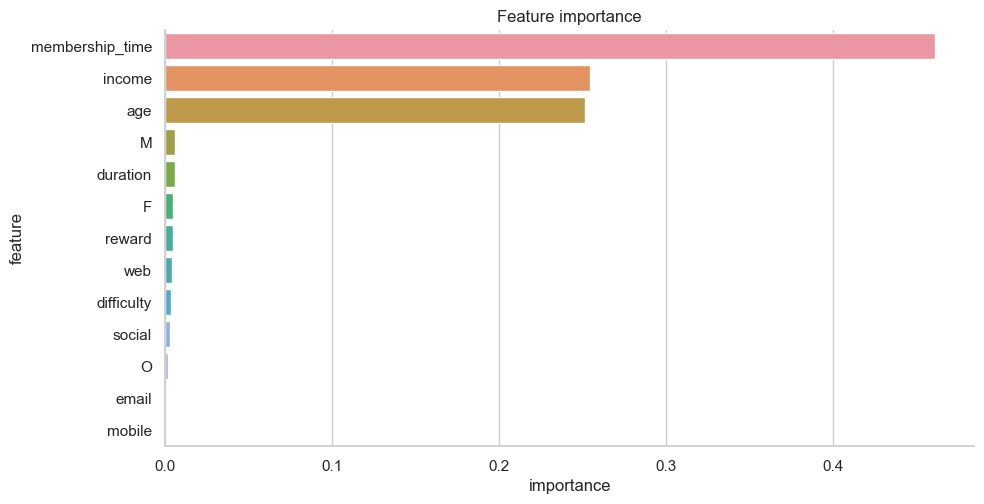

In [159]:
 most_important_features(data_bogo, bogo_random_forest)

## Discount  offers modelling

Same approach with Discount offers

In [160]:
discount_decision_tree = run_modelling(data_discount, 'offer_responded', DecisionTreeClassifier(max_depth=20, random_state=42))

DecisionTreeClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     0.9680    0.9150    0.9408      1224
           1     0.9866    0.9952    0.9909      7682

    accuracy                         0.9842      8906
   macro avg     0.9773    0.9551    0.9658      8906
weighted avg     0.9840    0.9842    0.9840      8906

Test sample report
              precision    recall  f1-score   support

           0     0.2954    0.3340    0.3135       497
           1     0.8983    0.8808    0.8895      3321

    accuracy                         0.8096      3818
   macro avg     0.5969    0.6074    0.6015      3818
weighted avg     0.8199    0.8096    0.8145      3818

Training F1 score:	 0.9908625494135183
Test F1 score:	 0.8894632811312149


In [161]:
discount_random_forest = run_modelling(data_discount, 'offer_responded', RandomForestClassifier(max_depth=20, random_state=42))

RandomForestClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     1.0000    0.9918    0.9959      1224
           1     0.9987    1.0000    0.9993      7682

    accuracy                         0.9989      8906
   macro avg     0.9993    0.9959    0.9976      8906
weighted avg     0.9989    0.9989    0.9989      8906

Test sample report
              precision    recall  f1-score   support

           0     0.3735    0.1247    0.1870       497
           1     0.8809    0.9687    0.9227      3321

    accuracy                         0.8588      3818
   macro avg     0.6272    0.5467    0.5549      3818
weighted avg     0.8148    0.8588    0.8269      3818

Training F1 score:	 0.9993495511903213
Test F1 score:	 0.9227018499928294


,feature,importance
0,membership_time,0.454748
1,income,0.256386
2,age,0.251626
3,M,0.006787
4,F,0.006325
5,social,0.006135
6,duration,0.004936
7,reward,0.004554
8,difficulty,0.004330
9,O,0.002673


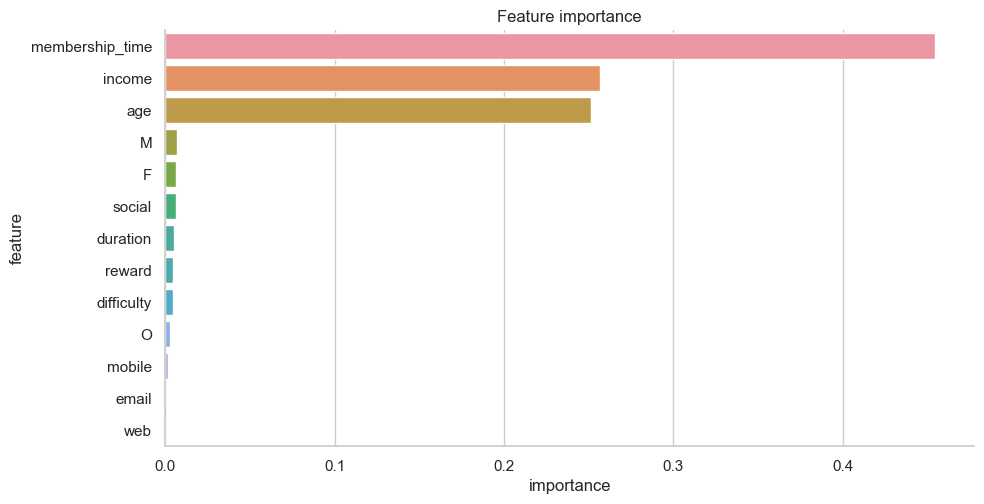

In [162]:
most_important_features(data_discount, discount_random_forest)

## Informational offers modelling

In [163]:
info_decision_tree = run_modelling(data_info, 'offer_responded', DecisionTreeClassifier(max_depth=20, random_state=42))

DecisionTreeClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     0.9781    0.9356    0.9564      1289
           1     0.9783    0.9928    0.9855      3768

    accuracy                         0.9782      5057
   macro avg     0.9782    0.9642    0.9709      5057
weighted avg     0.9782    0.9782    0.9781      5057

Test sample report
              precision    recall  f1-score   support

           0     0.3520    0.3876    0.3690       534
           1     0.7930    0.7668    0.7797      1634

    accuracy                         0.6734      2168
   macro avg     0.5725    0.5772    0.5743      2168
weighted avg     0.6844    0.6734    0.6785      2168

Training F1 score:	 0.9855110642781875
Test F1 score:	 0.7797137523335407


In [164]:
info_random_forest = run_modelling(data_info, 'offer_responded', RandomForestClassifier(max_depth=20, random_state=42))

RandomForestClassifier(max_depth=20, random_state=42)
Train sample report
              precision    recall  f1-score   support

           0     1.0000    0.9977    0.9988      1289
           1     0.9992    1.0000    0.9996      3768

    accuracy                         0.9994      5057
   macro avg     0.9996    0.9988    0.9992      5057
weighted avg     0.9994    0.9994    0.9994      5057

Test sample report
              precision    recall  f1-score   support

           0     0.3799    0.1985    0.2608       534
           1     0.7734    0.8941    0.8294      1634

    accuracy                         0.7228      2168
   macro avg     0.5767    0.5463    0.5451      2168
weighted avg     0.6765    0.7228    0.6893      2168

Training F1 score:	 0.9996020692399523
Test F1 score:	 0.8294067556060176


,feature,importance
0,membership_time,0.399350
1,income,0.295293
2,age,0.284186
3,M,0.005524
4,F,0.005349
5,O,0.003183
6,web,0.002605
7,social,0.002314
8,duration,0.002197
9,reward,0.000000


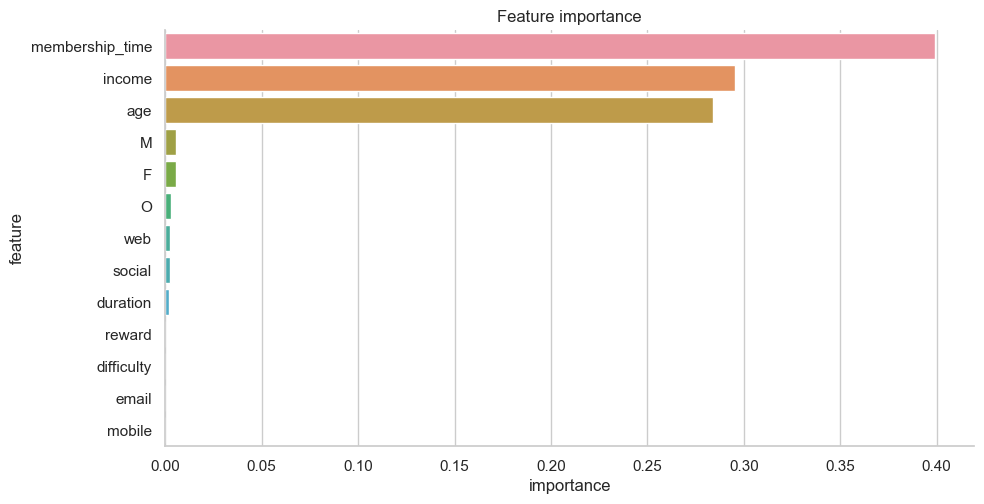

In [165]:
most_important_features(data_info, info_random_forest)

# Project conclusions

The goal of the project was to predict customer positive response on the Starbucks offer based on all available information. I created a simple classification model using Decision Tree classifier. Then compared it to the results of the Random Forest performance. The latter was better in all all 3 types of offers. I also verified the feature importance to check which variables do influence the target variable in most significant way.


The most relevant factors for all types of offers based on the modelling are:
* Membership_time
* Income
* Age

During the project the below steps allowed me to analyse and prepare the data:
1. Data exploration of 3 datasets:
    1. Portfolio
       1. Conversion of channels into separate columns
    2. Profile
        1. Removing rows with incorrect age
        2. Calculation of the membership time (which is one of the most important features
        3. Preparing the distribution of variables by gender
    3. Transcript
        1. Extracting additional information from values column

Data preprocessing:
1. Identification of the way to verify successful transactions
2. Filling missing `offer_id` data
3. Identification of customer groups and selecting the relevant ones for model training
4. Combining all the information and removing null values
5. Spliting the data into different offer types

Data modelling:
1. Preparing the comparison of Decision Tree and Random forest models for all 3 types of offers
2. Creating feature importance comparison for all 3 types of offers


Potential future improvement:

* Explore other classification models types
* Apply hyperparameter tuning
* Add additional variables with feature engineering

